In [1]:
from __future__ import print_function
import numpy as np
from kadi import events
from Ska.engarchive import fetch_eng as fetch
from Chandra.Time import DateTime
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
from astropy.table import Table
from Quaternion import Quat
from itertools import cycle
import astropy.units as u

## ObsID = 18983 ##

### Star centroids, obsid just before the bad maneuver ###

In [2]:
fetch.data_source.set('cxc')

In [3]:
start = '2017:090:17:00:00'
stop = '2017:090:18:27:00'

#if 'dat' not in globals():
dat = fetch.MSIDset(['aoacyan*', 'aoaczan*', 'aoacmag*'], start, stop)

In [4]:
t1 = '2017:090:17:13:00'
t2 = '2017:090:17:25:00'
t3 = '2017:090:17:32:00'
t4 = '2017:090:17:41:00'
t5 = '2017:090:17:56:15'
t6 = '2017:090:18:05:50'
t7 = '2017:090:18:10:50'
t8 = '2017:090:18:24:00'
t9 = stop

times = [t1, t2, t3, t4, t5, t6, t7, t8, t9]

In [5]:
idxs = []
for time in times:
    idx = (np.abs(dat['aoacmag0'].times - DateTime(time).secs)).argmin()
    idxs.append(idx)

Gray vertical lines: times t1-t6
Yellow vertical line: time t_2hp, to estimate the mag of the two hot pixels


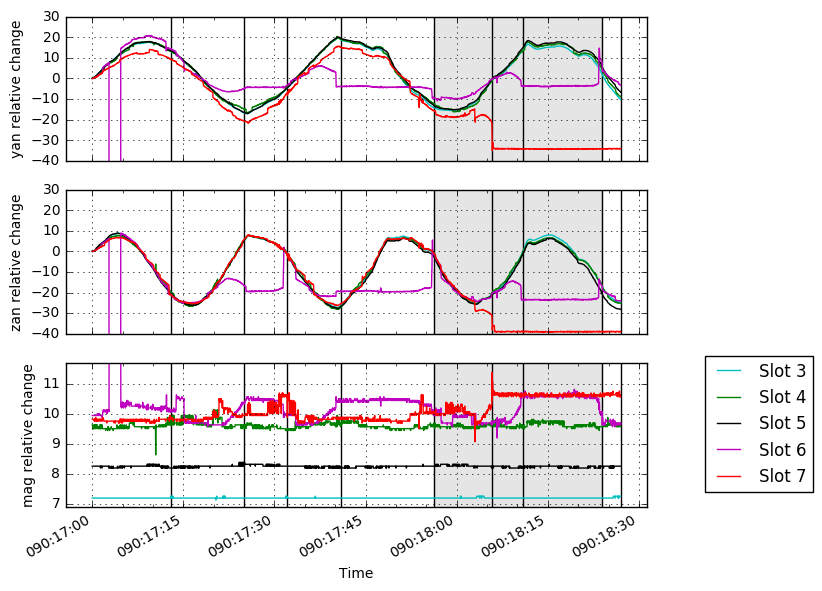

In [6]:
print("Gray vertical lines: times t1-t6")
print("Yellow vertical line: time t_2hp, to estimate the mag of the two hot pixels")

plt.close(1)
plt.figure(figsize=(7.5, 7))

ylims = [(-40, 30), (-40, 30), (6.9, 11.7)]

for idx, coord in enumerate(['yan', 'zan', 'mag']):
    plt.subplot(3, 1, idx + 1)
    for slot, color in zip(np.arange(3, 8), 'cgkmr'):
            msid = dat['aoac{}{}'.format(coord, slot)]
            if idx in [0, 1]:
                plot_cxctime(msid.times, msid.vals - msid.vals[0], color,
                             label='Slot {}'.format(slot))
            else:
                plot_cxctime(msid.times, msid.vals, color,
                             label='Slot {}'.format(slot))
    plt.ylim(ylims[idx])
    plt.ylabel("{} relative change".format(coord))
    plt.grid()
    plt.vlines(DateTime(times).plotdate, -40, 30, 'k')
    plt.margins(0.05)

plt.xlabel('Time')
plt.legend(loc=(1.1, 0.1))
axes = plt.gcf().axes
for ax in axes:
    ax.axvspan(DateTime(t5).plotdate, DateTime(t8).plotdate,
               color='gray', alpha=0.2)

plt.show()

### ACA image snapshots between 17:56:05 and 18:23:34 ###

<img style="float: left" src='snaps/17_56_05.png' width='670'> Just after star image<br>
is recovered in slot 6<br>
<img style="float: left" src='snaps/18_02_31.png' width='670'><br><br><br><br><br><br>
<img style="float: left" src='snaps/18_03_02.png' width='670'><br>Hot pixel takes over<br>
slot 7, another hot pixel<br> starts disturbing slot 6<br>
<img style="float: left" src='snaps/18_03_03.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_03_08.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_05_59.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_10_38.png' width='670'><br><br><br>Hot pixels tracked<br>
in slots 6 and 7<br><br>
<img style="float: left" src='snaps/18_23_34.png' width='670'><br>Star image recovered<br>
in slot 6<br>

### Identification of the two warm pixels ###

In [7]:
# 18:20:06
# Format: 2  VCDU: 14977284 (117010,004)  
# INT_TIME=   1.696 sec  CCD_Temp= -13.2  AChous_Temp= 27.6                           
# ---------SLOT 6 (-334,  38) (   1505  DN)----------------SLOT 7 (-327,-268) (   1517  DN)--------
# | 0     0     0     0     0     0     0     0 |     0     0     0     0     0     0     0     0 |
# | 0     0    40     2    31     0     0     0 |     0     0   101    30    33     5     0     0 |
# | 0     2     0     0     1     0     2     0 |     0    27    59    27    13    15     6     0 |
# | 0    -2    90     6   648    23    53     0 |     0    33     1    33    17    11     5     0 |
# | 0     3     6    56    83     5     5     0 |     0     3   146    12   756    71     5     0 |
# | 0    10     0   108    91    65     9     0 |     0    -1     3     7    29    43     7     0 |
# | 0     0    90     5    29    44     0     0 |     0     0     3     8     2     7     0     0 |
# | 0     0     0     0     0     0     0     0 |     0     0     0     0     0     0     0     0 |
# -------------------------------------------------------------------------------------------------

__Warm pixel values__

In [8]:
for slot, val in zip([6, 7], [648, 756]):
    x = val * 5 / 1.696
    print('Slot {:.0f}, warm pixel value = {:.0f} e-/sec'.format(slot, x))

Slot 6, warm pixel value = 1910 e-/sec
Slot 7, warm pixel value = 2229 e-/sec


In [9]:
from mica.archive import aca_l0, aca_dark
from chandra_aca import transform

dccimg = aca_dark.dark_cal.get_dark_cal_image('2017:010', select='nearest', aca_image=True)

d = events.dwells.filter(obsid=18983)[0]

times = ['2017:090:18:20:06', '2017:090:18:20:10']

for slot in [6, 7]:
    slot_data = aca_l0.get_slot_data(times[0], times[1], slot=slot)
    slot_data = Table(slot_data)
    row0 = slot_data['IMGROW0'][0]
    col0 = slot_data['IMGCOL0'][0]
    imgraw = slot_data['IMGRAW'][0]
    bgdavg = slot_data['BGDAVG'][0]

    data = imgraw.data
    idx = list(data).index(np.max(data))
    col = idx // 8 + col0
    row = np.mod(idx, 8) + row0
    
    print('Slot {}'.format(slot))
    print('Coords of warm pixel (row, col) = ({}, {})'.format(row, col))
    print()
    
    print('Check: Transform row/col to yag/zag and compare with observed yag/zag:')
    
    yag, zag = transform.pixels_to_yagzag(row, col)
    print('    Transformed (yag, zag) = ({:.3f}, {:.3f})'.format(yag, zag))
    
    idx = (np.abs(dat['aoacyan{}'.format(slot)].times - DateTime(times[0]).secs)).argmin()    
    yag = dat['aoacyan{}'.format(slot)].vals[idx]
    zag = dat['aoaczan{}'.format(slot)].vals[idx]
    print('    Observed (yag, zag) = ({:.3f}, {:.3f})'.format(yag, zag))
    print()
    
    section = dccimg[512 + row - 2: 512 + row + 2, 512 + col - 2: 512 + col + 2]
    print(section)
    print()
        

Slot 6
Coords of warm pixel (row, col) = (40, -332)

Check: Transform row/col to yag/zag and compare with observed yag/zag:
    Transformed (yag, zag) = (-172.082, -1677.795)
    Observed (yag, zag) = (-170.950, -1675.600)

[[   26.   246.   274.   108.]
 [   33.   140.   256.    24.]
 [  204.    70.  1860.    89.]
 [   30.    16.    34.    37.]]

Slot 7
Coords of warm pixel (row, col) = (-266, -326)

Check: Transform row/col to yag/zag and compare with observed yag/zag:
    Transformed (yag, zag) = (1349.324, -1647.405)
    Observed (yag, zag) = (1348.775, -1641.900)

[[   33.    20.    13.   116.]
 [   31.   336.    26.  1861.]
 [  157.    21.   128.    36.]
 [  111.   158.    83.    29.]]



ACA dark current calibration taken on 2017/010 shows two pixels with value 1860 e-/sec at the coordinates adjacent to those of warm pixels observed in slots 6 and 7.

### Probability of hitting hot pixels with >2000 e-/sec in *N* image windows###

The two warm pixels in slots 6 and 7 were observed at approximately 2000 e-/sec. According to the dark current calibration taken on 2017/010, ACA CCD has approximately 100 pixels with value >= 2000 e-/sec.

<img style='float: left' src='cum_dist.gif'>

In [34]:
def get_hot_pixel_hits(ccd_size, n_hp, n_image_windows):
    
    ccd = np.zeros(ccd_size * ccd_size)
    
    # hot pixel coordinates
    hp_coords = np.random.randint(1, ccd_size, 2 * n_hp)
    hp_coords = hp_coords.reshape(2, n_hp)
    
    # draw row0, col0 of 5 image windows
    # add check if the windows overlap
    row0col0 = np.random.randint(1, ccd_size, 2 * n_image_windows)
    row0col0 = row0col0.reshape(2, n_image_windows)

    # 12 x 12 to include pixels covered due to dither
    sz = 12
    scheduled_pixels = []

    for row0, col0 in zip(row0col0[0], row0col0[1]):
        for rr in range(sz):
            for cc in range(sz):
                scheduled_pixels.append((row0 + rr, col0 + cc))
                
    hits = 0
    for hp_row, hp_col in zip(hp_coords[0], hp_coords[1]):
        if (hp_row, hp_col) in scheduled_pixels:
            hits = hits + 1
            
    return hits

In [35]:
ccd_size = 1024
n_hp = 100
n_image_windows = 5

probs = {}
distr = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0}
n_trials = 20000
for i in range(n_trials):
    hits = get_hot_pixel_hits(ccd_size, n_hp, n_image_windows)
    distr['{}'.format(hits)] = distr['{}'.format(hits)] + 1
    
print(distr)

for key in distr.keys():
    probs[key] = distr[key] / n_trials
    
print(probs)

{'2': 37, '4': 0, '5': 0, '3': 0, '1': 1235, '0': 18728}
{'2': 0.00185, '1': 0.06175, '5': 0.0, '3': 0.0, '4': 0.0, '0': 0.9364}


In [36]:
ccd_size = 1024
n_hp = 100
n_image_windows = 8

probs = {}
distr = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0}
n_trials = 20000
for i in range(n_trials):
    hits = get_hot_pixel_hits(ccd_size, n_hp, n_image_windows)
    distr['{}'.format(hits)] = distr['{}'.format(hits)] + 1
    
print(distr)

for key in distr.keys():
    probs[key] = distr[key] / n_trials
    
print(probs)

{'2': 107, '4': 0, '5': 0, '3': 8, '1': 1952, '0': 17933}
{'2': 0.00535, '1': 0.0976, '5': 0.0, '3': 0.0004, '4': 0.0, '0': 0.89665}


### Change in Ground and OBC atitude estimates ###

In [11]:
#OBSID: 18983  IGR J16120-3543        ACIS-I SIM Z offset:0     (0.00mm) Grating: NONE 
#RA, Dec, Roll (deg):   242.979061   -35.773101    69.916905
#Dither: ON  Y_amp=16.0  Z_amp=16.0  Y_period=2000.0  Z_period=1414.8
#
#MP_TARGQUAT at 2017:090:16:35:48.735 (VCDU count = 14952866)
#  Q1,Q2,Q3,Q4: 0.49947489  -0.33350427  -0.75701845  0.25733791

Q1, Q2, Q3, Q4 = [0.49947489, -0.33350427, -0.75701845, 0.25733791]
q_planned = Quat([Q1, Q2, Q3, Q4])

In [12]:
#import Ska.arc5gl
#arc5gl = Ska.arc5gl.Arc5gl()
#arc5gl.sendline('obsid=18983')
#arc5gl.sendline('version=last')
#arc5gl.sendline('get asp1{obcsol}')
#del arc5gl

In [13]:
obc_file = 'pcadf607365442N001_osol1.fits.gz'
obc_sol = Table.read(obc_file)[1336:]

In [14]:
#print(grnd_sol['time'][0] - obc_sol['time'][1336])
#print(grnd_sol['time'][-1] -obc_sol['time'][-1])

In [15]:
asol_file = 'pcadf607366811N001_asol1.fits.gz'
grnd_sol = Table.read(asol_file)

In [16]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(atts['time'], drs, '-b', label='Roll')
    plot_cxctime(atts['time'], dps, '-g', label='Pitch')
    plot_cxctime(atts['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.xlabel('Time')
    #plt.legend(loc='best');

In [17]:
dat = fetch.MSIDset(['aogbias*'], start=grnd_sol['time'][0], stop=grnd_sol['time'][-1])

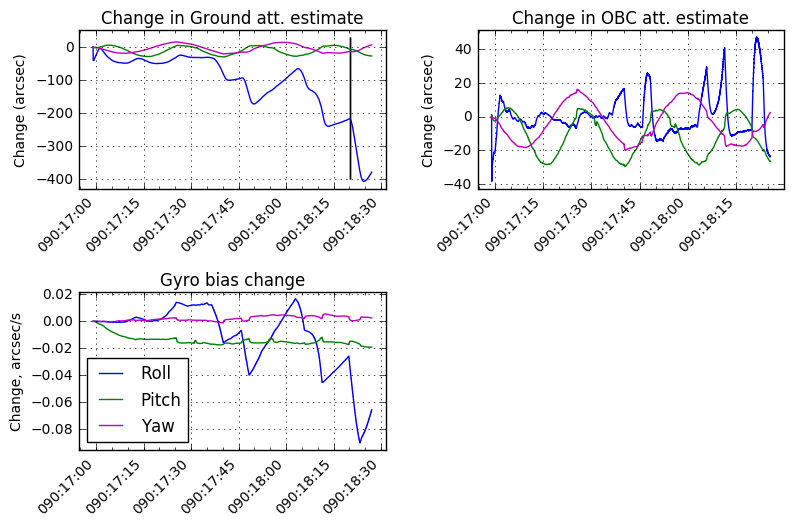

In [18]:
plt.figure(figsize=(7.5, 6))

plt.subplot(2, 2, 1)

label = 'Change in Ground att. estimate'
plot_att_changes(refs=grnd_sol[:1], atts=grnd_sol, label=label)
plt.vlines(DateTime(times).plotdate, -400, 30, 'k')

plt.subplot(2, 2, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=obc_sol[:1], atts=obc_sol, label=label)

# Gyro bias
plt.subplot(2, 2, 3)

labels = ['Roll', 'Pitch', 'Yaw']
for i, color in zip(range(3), 'bgm'):
    msid = dat['aogbias{}'.format(i + 1)]
    plot_cxctime(msid.times,
                 ((msid.vals - msid.vals[0]) * u.radian / u.s).to('arcsec/s'),
                 color=color,
                 label=labels[i])
plt.grid()
plt.margins(0.05)
plt.ylabel('Change, arcsec/s')
plt.title('Gyro bias change')
plt.legend(loc='best')

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3, hspace=0.65)

plt.show()

## ObsID = 19924 ##

### Change in OBC estimated attitude relative to the final BSH attitude###

In [19]:
start = '2017:090:18:54:00'
stop = '2017:090:19:15:00'
dat_seq = fetch.MSID('aoacaseq', start, stop)

In [20]:
vals = []
seqs = ['BRIT', 'AQXN', 'GUID', 'KALM']
for i, seq in enumerate(seqs):
    vals.append((dat_seq.vals == seq) * (i + 1))

In [21]:
obc_file = 'pcadf607372002N001_osol1.fits.gz'
obc_sol = Table.read(obc_file)[1666:2894]

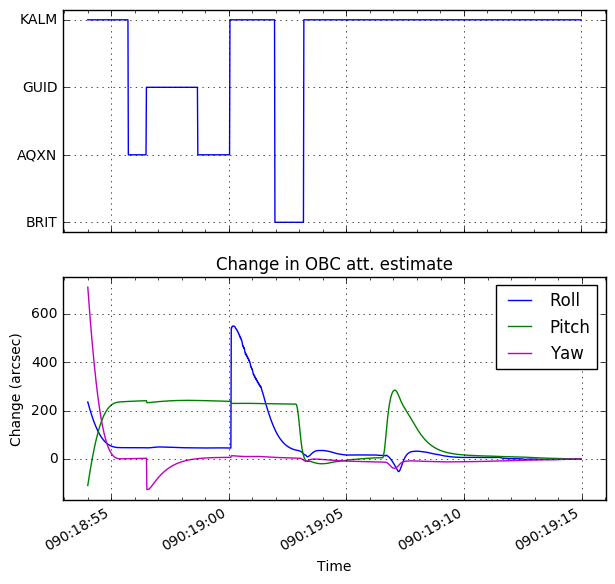

In [22]:
plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)

plot_cxctime(dat_seq.times, np.sum(vals, axis=0))
plt.yticks([1, 2, 3, 4], seqs)
plt.grid()
plt.margins(0.05)

plt.subplot(2, 1, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=obc_sol[-1:], atts=obc_sol, label=label)
plt.legend(loc='best')
plt.margins(0.05)

plt.show()

In [23]:
#dump2occ.py 2017_090_1147_090_2026_Dump_EM_54052N001.sto | splat.pl -vcdu 14952866

<img style="float: left" src='snaps/18_56_31.png' width='670'> 1st ACXN, <br>
Slot 2, star<br>Slot 6, warm pixel<br>
<img style="float: left" src='snaps/18_57_00.png' width='670'> <br><br>GUID <br><br>
<img style="float: left" src='snaps/18_57_56.png' width='670'> <br><br>GUID, <br>
Slot 2, star corrupted<br>
due to a hot pixel?<br>
<img style="float: left" src='snaps/18_58_17.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_26.png' width='670'><br><br> 2nd AQXN,<br>
Slots 0-2 FIDs<br>Slots 6-7 hot pixels<br>
<img style="float: left" src='snaps/18_58_30.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_42.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_51.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_54.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_57.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/19_00_02.png' width='670'><br><br><br>KALM<br>
Slot 2, same star<br>
as during the 1st AQXN<br>
<img style="float: left" src='snaps/19_02_10.png' width='670'><br><br>KALM -> BRIT<br>
<img style="float: left" src='snaps/19_03_11.png' width='670'><br><br><br>BRIT -> KALM<br>
Slot 6, slightly affected<br> by a hot pixel<br>
<img style="float: left" src='snaps/19_07_18.png' width='670'>
<img style="float: left" src='snaps/19_07_45.png' width='670'>
<img style="float: left" src='snaps/19_07_52.png' width='670'>
<img style="float: left" src='snaps/19_08_43.png' width='670'>

In [24]:
start = '2017:090:18:56:32'
stop = '2017:090:20:00:00'

dat_bsh = fetch.MSIDset(['aoacyan*', 'aoaczan*'], start, stop)

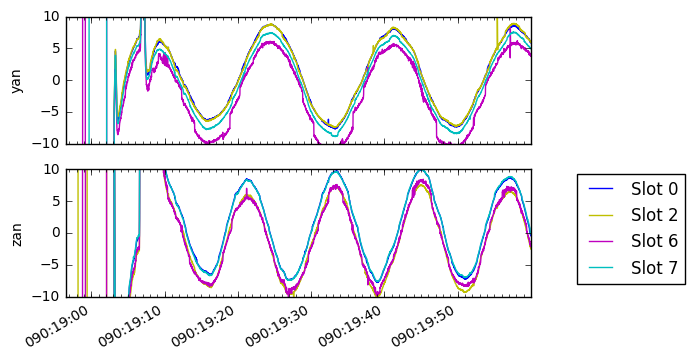

In [25]:
plt.close(1)
plt.figure(1)
plt.subplot(2, 1, 1)
for slot, color in zip([0, 2, 6, 7], 'bymc'):
    msid = dat_bsh['aoacyan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color)
plt.ylim(-10, 10)
plt.ylabel("yan")

plt.subplot(2, 1, 2)
for slot, color in zip([0, 2, 6, 7], 'bymc'):
    msid = dat_bsh['aoaczan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - np.median(msid.vals), color,
                label='Slot {}'.format(slot))
plt.ylim(-10, 10)
plt.ylabel("zan")

plt.legend(loc=(1.1, 0.1))

plt.show()

## Slot 2 star, ID = 1200884696 ##

In [26]:
import agasc
import Ska.quatutil as quatutil

In [27]:
t = Table(agasc.agasc.get_star(1200884696))
print(t['AGASC_ID', 'RA', 'DEC', 'MAG_ACA'])

 AGASC_ID       RA         DEC      MAG_ACA
---------- ----------- ------------ -------
1200884696 79.22406139 -68.35254583 9.69701


In [28]:
dat_att = fetch.MSIDset(['aoattqt*'], start, stop)

In [30]:
# Nominal 19924 attitude (use quat from Tom's notebook)
#q_true = Quat([-0.732787795684,   -0.192090020230,    0.650382328621,    0.055913301117])

idx = (np.abs(dat_bsh['aoacyan0'].times - DateTime('2017:090:19:15:00').secs)).argmin()

q_true = []
for i in range(4):
    q_true.append(dat_att['aoattqt{}'.format(i + 1)].vals[idx])   
q_true = Quat(q_true)

roll = q_true.roll + 529. / 3600
pitch = q_true.pitch + 219. / 3600
q_guid = Quat((q_true.ra, -pitch, roll))

yaw = q_true.yaw - 116. / 3600
q_aqxn1 = Quat((yaw, -pitch, roll))

In [31]:
ra = t['RA'][0]
dec = t['DEC'][0]

tstar = Table(names=('slot', 'yag_o', 'yag_p', 'dyag', 'zag_o', 'zag_p', 'dzag'))

quats = [q_true, q_guid, q_aqxn1]
slots = [6, 2, 2]
times = ['2017:090:19:15:00', '2017:090:18:58:00', '2017:090:18:56:31']

for quat, slot, time in zip(quats, slots, times):
    msidy = 'aoacyan{}'.format(slot)
    msidz = 'aoaczan{}'.format(slot)
    idx = (np.abs(dat_bsh['aoacyan0'].times - DateTime(time).secs)).argmin()
    yag_o, zag_o = (dat_bsh[msidy].vals[idx], dat_bsh[msidz].vals[idx])
    yag_p, zag_p = quatutil.radec2yagzag(ra, dec, quat)
    dyag = yag_o - yag_p * 3600
    dzag = zag_o - zag_p * 3600
    tstar.add_row([slot,
                   yag_o, yag_p * 3600, dyag,
                   zag_o, zag_p * 3600, dzag])

tstar['slot'].format = '%2i'
cols = tstar.colnames
cols.remove('slot')
for col in cols:
    tstar[col].format = '%.3f'

tstar['seq'] = ['BRIT', 'GUID', 'AQXN1']
    
print(tstar)

slot   yag_o     yag_p     dyag   zag_o    zag_p     dzag   seq 
---- --------- --------- ------- -------- -------- ------- -----
   6 -2182.150 -2181.187  -0.963 1678.550 1673.619   4.931  BRIT
   2 -2172.000 -2377.387 205.387 1915.250 1591.144 324.106  GUID
   2 -2057.450 -2393.425 335.975 1906.175 1630.820 275.355 AQXN1
